In [14]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://rawgit.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

    
    
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)



In [11]:
fetch_housing_data()

In [81]:
housing = load_housing_data()

In [22]:
# A number of was to show the data to gain insight into what is happening so far.
# housing.head()
# housing.info()
# housing.describe()
# %matplotlib inline
# import matplotlib.pyplot as plt
# housing.hist(bins=50, figsize=(20, 15))
# plt.show()

In [27]:
# Train-Test Split
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)

# print(len(train_set), "train +", len(test_set), "test")


In [34]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio
    
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    # IDs for the incoming data
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]


#Approach using the row index of the table
housing_with_id = housing.reset_index() # adds index column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

#Approch using a constant paramter that can be either used already or calculated
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

# Approach using the scikit learn built in function for train-test splitting
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

#Approach using Stratified sampling: meaning groupings (strata) under a similar category term

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)

#    All incomes determined to be not matching(false) accoridng to the boolean
#    operation go into category 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

# Approach using Stratified sampling in SKLearn
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

#housing["income_cat"].value_counts() / len(housing)

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)


In [115]:
housing = strat_train_set.copy()

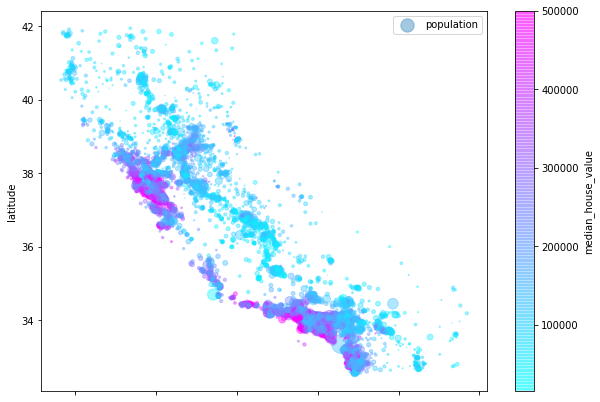

In [48]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
             s=housing["population"]/100, label="population", figsize=(10,7),
            c="median_house_value", cmap=plt.get_cmap("cool"), colorbar=True)


plt.legend()

In [51]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a239d56d8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11f3d4128>]], dtype=object)

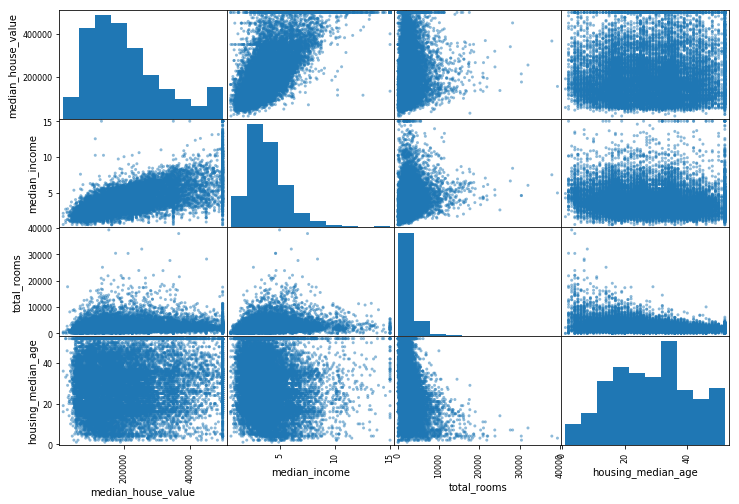

In [53]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

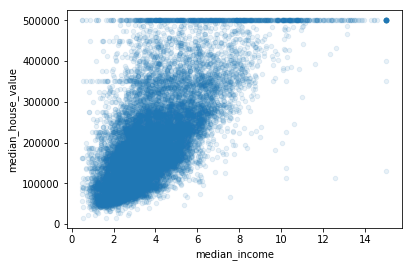

In [54]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [57]:
#Calculated featured of the data to get some more meaning out of the metrics.
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [61]:
#PREPARE DATA FOR ML ALGORITHMS
# Get the housing data except for the median house value which we are after
housing = strat_train_set.drop("median_house_value", axis=1)

# Get the housing data actual median values
housing_labels = strat_train_set["median_house_value"].copy()

#CLEAN DATA
# Ways of getting rid of the None values
# You need to do this for all the values that are missing or not in the proper format
# To be useful for an ML algorithm. 
# It could actually cause the algorithm to be biased and see things that 
# are only there because of mistakes in data formating

# Option 1 remove the data points entirely where the missing data is present
#housing.dropna(subset=["total_bedrooms"])

#Option 2 get rid of the entire attribute
#housing.drop("total_bedrooms", axis=1)

#Option 3 fill in or format the values in a formal way
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

housing_num = housing.drop("ocean_proximity", axis=1)

from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
imputer.fit(housing_num)

#imputer.statistics_
#housing_num.median().values


array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [62]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

# Make labels that are strings into enumerations basically using numbers
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [63]:
# you can look at label encoding using the classes_ property
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], dtype=object)

In [64]:
# One hot encoding is a means to alleviate the problem of having disimilar nearby values
# not be counted as similar and there for on a continuous spectrum. 

# will change 3 to [0,0,0,1,0] if there were 5 options 0-4
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# this creates a NumberOfSamples by NumberOfOptions sparse matrix
# sparse matrix means instead of storing the 0s it stores the the index of the 1 at that place and then 
# when it is read as an array it can be converted later. To save space. 
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [65]:
#This is how it is read as an array
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [69]:
# The previous method did this in two steps using the LabelEncoder 
# and then from the label encoder doing one hot encoding
# However this can be taken care of in one step using LabelBinarizer from SKLearn

from sklearn.preprocessing import LabelBinarizer

# By default the output is a dense Numpy Array however if we want a sparse matrix
# we can specify that in the constructor function
encoder = LabelBinarizer(sparse_output=True)
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot


<16512x5 sparse matrix of type '<class 'numpy.int64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [70]:

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
    
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)



In [74]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# This creates a pipeline.
# which means that it does each of these actions in a row
num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

# Transform the numbered housing data using the above pipeline
housing_num_tr = num_pipeline.fit_transform(housing_num)



In [108]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
class LabelBinarizerPipelineFriendly(LabelBinarizer):
     def fit(self, X, y=None):
         #this would allow us to fit the model based on the X input.
         return super(LabelBinarizerPipelineFriendly, self).fit(X)
        
     def transform(self, X, y=None):
         return super(LabelBinarizerPipelineFriendly, self).transform(X)
 
     def fit_transform(self, X, y=None):
         return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)
 
 
    


In [116]:
# We want a pipeline that not only runs the appropriate transforms
# but also converts the data at the beginning so that it can be input more easily

# running list on housing_num will give you a list fo the feature names


num_attributes = list(housing_num)
cat_attributes = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attributes)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attributes)),
    ('encode_part_I', LabelBinarizerPipelineFriendly())
])

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

# this CAN run on the full set (train + test) but this housing is only referring to the training set
# don't do what he did and simply overload housing; not clear for future.
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape


(16512, 16)

In [117]:

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [118]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepended = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepended))

Predictions: [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]


In [119]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [120]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489234

In [121]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)



DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [122]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [127]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Stdev: ", scores.std())
    
display_scores(tree_rmse_scores)

Scores:  [ 67821.83629814  66810.63128506  71874.60552741  69643.85500586
  70142.80323186  74646.9326067   69893.48154761  70205.4619311
  77043.66567106  69959.34849065]
Mean:  70804.2621595
Stdev:  2887.41915333


In [130]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                            scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean:  69052.4613635
Stdev:  2731.6740018


In [132]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

randomforest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                            scoring="neg_mean_squared_error", cv=10)

randomforest_rmse_scores = np.sqrt(-randomforest_scores)
display_scores(randomforest_rmse_scores)


Scores:  [ 52547.60758496  50424.09541081  52202.11086668  54705.66755938
  52992.68256617  55579.67003996  51014.96604308  50050.80015245
  56138.37522731  53018.14969941]
Mean:  52867.412515
Stdev:  1983.7514189


In [136]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30, 50, 100], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30, 50, 100], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [137]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 100}

In [139]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [142]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64050.354787 {'n_estimators': 3, 'max_features': 2}
55772.1497178 {'n_estimators': 10, 'max_features': 2}
53079.552971 {'n_estimators': 30, 'max_features': 2}
52352.9630503 {'n_estimators': 50, 'max_features': 2}
51923.714705 {'n_estimators': 100, 'max_features': 2}
59891.0243134 {'n_estimators': 3, 'max_features': 4}
52982.4986644 {'n_estimators': 10, 'max_features': 4}
50570.047867 {'n_estimators': 30, 'max_features': 4}
49914.3318078 {'n_estimators': 50, 'max_features': 4}
49726.6242115 {'n_estimators': 100, 'max_features': 4}
58512.299601 {'n_estimators': 3, 'max_features': 6}
52625.8866492 {'n_estimators': 10, 'max_features': 6}
50176.1029031 {'n_estimators': 30, 'max_features': 6}
49616.9162689 {'n_estimators': 50, 'max_features': 6}
49280.5943691 {'n_estimators': 100, 'max_features': 6}
58292.2624817 {'n_estimators': 3, 'max_features': 8}
52105.7043465 {'n_estimators': 10, 'max_features': 8}
50119.9429076 {'n_estimators': 30, 'max_features': 8}
49710.4636668 {'n_estimators': 50,

In [143]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.03821358e-02,   6.38437607e-02,   4.32820199e-02,
         1.52765907e-02,   1.48195882e-02,   1.52236779e-02,
         1.41876636e-02,   3.63709172e-01,   4.46080295e-02,
         1.11597051e-01,   7.30884487e-02,   6.64924286e-03,
         1.57738871e-01,   8.11208889e-05,   2.29785096e-03,
         3.21477716e-03])